In [1]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import os
import sys
import glob

In [2]:
project_root = os.path.abspath('..')
if project_root not in sys.path:
    sys.path.insert(0, project_root)

In [3]:
IMG_SIZE = (224, 224)

def load_image_mask(image_path, mask_path):
    # Load image
    image = tf.io.read_file(image_path)
    image = tf.image.decode_png(image, channels=3)
    image = tf.image.resize(image, IMG_SIZE)
    image = tf.cast(image, tf.float32)/255.0
    
    # Load mask
    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=1)
    mask = tf.image.resize(mask, IMG_SIZE, method='nearest')
    mask = tf.cast(mask>0, tf.float32)
    
    return image, mask

In [4]:
image_dir = '/Users/alex/Desktop/NeuroRex/data/mri_tumor_segmentation/images'
mask_dir = '/Users/alex/Desktop/NeuroRex/data/mri_tumor_segmentation/masks'

In [5]:
image_paths = sorted(glob.glob(os.path.join(image_dir, '*.png')), key=lambda x: int(os.path.basename(x).split('.')[0]))
mask_paths = sorted(glob.glob(os.path.join(mask_dir, '*.png')), key=lambda x: int(os.path.basename(x).split('.')[0]))

In [6]:
train_img, temp_img, train_mask, temp_mask = train_test_split(image_paths, mask_paths, test_size=0.2, random_state=42)

In [7]:
val_img, test_img, val_mask, test_mask = train_test_split(temp_img, temp_mask, test_size=0.5, random_state=42)

In [8]:
def make_dataset(img_ds, mask_ds, batch_size=16, shuffle=True):
    dataset = tf.data.Dataset.from_tensor_slices((img_ds, mask_ds))
    dataset = dataset.map(load_image_mask, num_parallel_calls=tf.data.AUTOTUNE)
    if shuffle:
        dataset = dataset.shuffle(1000)
    dataset = dataset.batch(batch_size).prefetch(tf.data.AUTOTUNE)
    return dataset

In [9]:
train_ds = make_dataset(train_img, train_mask)
val_ds = make_dataset(val_img, val_mask, shuffle=False)
test_ds = make_dataset(test_img, test_mask, shuffle=False)

2025-04-26 19:32:18.542677: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M1
2025-04-26 19:32:18.542700: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 8.00 GB
2025-04-26 19:32:18.542710: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 2.67 GB
2025-04-26 19:32:18.542758: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-04-26 19:32:18.543368: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


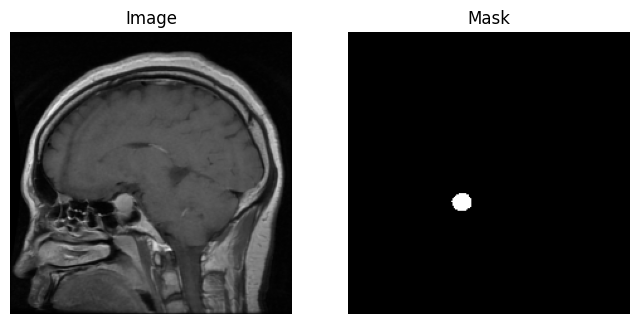

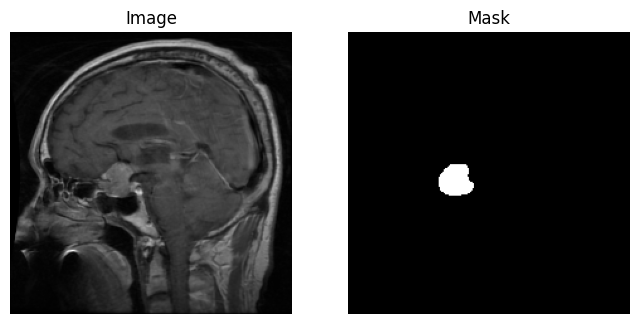

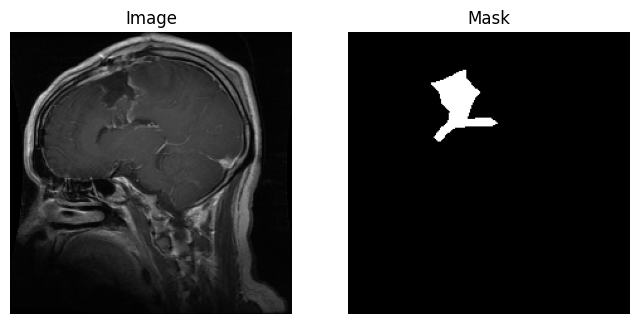

In [10]:
def visualize_batch(dataset, num=3):
    for images, masks in dataset.take(1):
        for i in range(num):
            plt.figure(figsize=(8,4))
            plt.subplot(1, 2, 1)
            plt.imshow(images[i])
            plt.title('Image')
            plt.axis('off')
            
            plt.subplot(1, 2, 2)
            plt.imshow(tf.squeeze(masks[i]), cmap='gray')
            plt.title('Mask')
            plt.axis('off')
            plt.show()

visualize_batch(train_ds)

In [11]:
def build_model():
    inputs = tf.keras.Input(shape=(224, 224, 3), name="input_layer")

    # Encoder
    c1 = tf.keras.layers.Conv2D(64, (3, 3), activation="relu", padding="same", name="conv2d")(inputs)
    c1 = tf.keras.layers.Conv2D(64, (3, 3), activation="relu", padding="same", name="conv2d_1")(c1)
    p1 = tf.keras.layers.MaxPooling2D((2, 2), name="max_pooling2d")(c1)

    c2 = tf.keras.layers.Conv2D(128, (3, 3), activation="relu", padding="same", name="conv2d_2")(p1)
    c2 = tf.keras.layers.Conv2D(128, (3, 3), activation="relu", padding="same", name="conv2d_3")(c2)
    p2 = tf.keras.layers.MaxPooling2D((2, 2), name="max_pooling2d_1")(c2)

    c3 = tf.keras.layers.Conv2D(256, (3, 3), activation="relu", padding="same", name="conv2d_4")(p2)
    c3 = tf.keras.layers.Conv2D(256, (3, 3), activation="relu", padding="same", name="conv2d_5")(c3)
    p3 = tf.keras.layers.MaxPooling2D((2, 2), name="max_pooling2d_2")(c3)

    c4 = tf.keras.layers.Conv2D(512, (3, 3), activation="relu", padding="same", name="conv2d_6")(p3)
    c4 = tf.keras.layers.Conv2D(512, (3, 3), activation="relu", padding="same", name="conv2d_7")(c4)
    p4 = tf.keras.layers.MaxPooling2D((2, 2), name="max_pooling2d_3")(c4)

    c5 = tf.keras.layers.Conv2D(1024, (3, 3), activation="relu", padding="same", name="conv2d_8")(p4)
    c5 = tf.keras.layers.Conv2D(1024, (3, 3), activation="relu", padding="same", name="conv2d_9")(c5)

    # Decoder
    u6 = tf.keras.layers.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding="same", name="conv2d_transpose")(c5)
    u6 = tf.keras.layers.Concatenate(name="concatenate")([u6, c4])
    c6 = tf.keras.layers.Conv2D(512, (3, 3), activation="relu", padding="same", name="conv2d_10")(u6)
    c6 = tf.keras.layers.Conv2D(512, (3, 3), activation="relu", padding="same", name="conv2d_11")(c6)

    u7 = tf.keras.layers.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding="same", name="conv2d_transpose_1")(c6)
    u7 = tf.keras.layers.Concatenate(name="concatenate_1")([u7, c3])
    c7 = tf.keras.layers.Conv2D(256, (3, 3), activation="relu", padding="same", name="conv2d_12")(u7)
    c7 = tf.keras.layers.Conv2D(256, (3, 3), activation="relu", padding="same", name="conv2d_13")(c7)

    u8 = tf.keras.layers.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding="same", name="conv2d_transpose_2")(c7)
    u8 = tf.keras.layers.Concatenate(name="concatenate_2")([u8, c2])
    c8 = tf.keras.layers.Conv2D(128, (3, 3), activation="relu", padding="same", name="conv2d_14")(u8)
    c8 = tf.keras.layers.Conv2D(128, (3, 3), activation="relu", padding="same", name="conv2d_15")(c8)

    u9 = tf.keras.layers.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding="same", name="conv2d_transpose_3")(c8)
    u9 = tf.keras.layers.Concatenate(name="concatenate_3")([u9, c1])
    c9 = tf.keras.layers.Conv2D(64, (3, 3), activation="relu", padding="same", name="conv2d_16")(u9)
    c9 = tf.keras.layers.Conv2D(64, (3, 3), activation="relu", padding="same", name="conv2d_17")(c9)

    outputs = tf.keras.layers.Conv2D(1, (1, 1), activation="sigmoid", name="conv2d_18")(c9)

    model = tf.keras.models.Model(inputs, outputs, name="functional")
    return model

model = build_model()
model.summary()

Model: "functional"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_layer (InputLayer)    [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 224, 224, 64)         1792      ['input_layer[0][0]']         
                                                                                                  
 conv2d_1 (Conv2D)           (None, 224, 224, 64)         36928     ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 112, 112, 64)         0         ['conv2d_1[0][0]']            
 D)                                                                                      

In [12]:
def dice_loss(y_true, y_pred, smooth=1e-6):
    y_true = tf.cast(y_true, tf.float32)
    y_pred = tf.cast(y_pred, tf.float32)

    # Clip y_pred to avoid extreme values
    y_pred = tf.clip_by_value(y_pred, 1e-7, 1-1e-7)

    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])

    intersection = tf.reduce_sum(y_true_f * y_pred_f)
    denominator = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f)

    dice = (2. * intersection + smooth) / (denominator + smooth)
    return 1 - dice

In [13]:
def combined_loss(y_true, y_pred):
    bce = tf.keras.losses.binary_crossentropy(y_true, y_pred)
    d_loss = dice_loss(y_true, y_pred)
    return bce+d_loss

In [14]:
def dice_coef(y_true, y_pred, smooth=1e-6):
    y_pred = tf.cast(y_pred, tf.float32)
    y_true = tf.cast(y_true, tf.float32)
    y_true_f = tf.reshape(y_true, [-1])
    y_pred_f = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true_f*y_pred_f)
    return (2. * intersection + smooth) / (tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) + smooth)


In [15]:
model.compile(optimizer=tf.keras.optimizers.Adam(1e-4),
              loss=combined_loss,
              metrics=['accuracy', dice_coef])

In [16]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_dice_coef',
    patience=5,
    mode='max',
    restore_best_weights=True
)

In [17]:
history = model.fit(train_ds, validation_data = val_ds, epochs=20, callbacks=[early_stop])

Epoch 1/20


2025-04-26 19:32:22.670088: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:117] Plugin optimizer for device_type GPU is enabled.
2025-04-26 19:32:22.846678: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] model_pruner failed: INVALID_ARGUMENT: Graph does not contain terminal node Adam/AssignAddVariableOp.


154/154 [==============================] - 539s 3s/step - loss: 1.0818 - accuracy: 0.9826 - dice_coef: 0.0741 - val_loss: 0.9586 - val_accuracy: 0.9833 - val_dice_coef: 0.1270
Epoch 2/20
154/154 [==============================] - 740s 5s/step - loss: 0.8985 - accuracy: 0.9811 - dice_coef: 0.1827 - val_loss: 0.7939 - val_accuracy: 0.9818 - val_dice_coef: 0.2945
Epoch 3/20
154/154 [==============================] - 704s 5s/step - loss: 0.7132 - accuracy: 0.9817 - dice_coef: 0.3685 - val_loss: 0.6648 - val_accuracy: 0.9853 - val_dice_coef: 0.4116
Epoch 4/20
154/154 [==============================] - 728s 5s/step - loss: 0.6210 - accuracy: 0.9845 - dice_coef: 0.4502 - val_loss: 0.6341 - val_accuracy: 0.9871 - val_dice_coef: 0.4379
Epoch 5/20
154/154 [==============================] - 757s 5s/step - loss: 0.5546 - accuracy: 0.9858 - dice_coef: 0.5107 - val_loss: 0.5345 - val_accuracy: 0.9871 - val_dice_coef: 0.5465
Epoch 6/20
154/154 [==============================] - 757s 5s/step - loss: 0

In [18]:
model.evaluate(test_ds)

20/20 [==============================] - 25s 1s/step - loss: 0.2194 - accuracy: 0.9942 - dice_coef: 0.8074


[0.2193795144557953, 0.9941564798355103, 0.8074458241462708]

In [19]:
tf.keras.models.save_model(model, '/Users/alex/Desktop/NeuroRex/models/mri_tumor_segmentation/segmentation_mri.keras')
tf.keras.models.save_model(model, '/Users/alex/Desktop/NeuroRex/models/mri_tumor_segmentation/segmentation_mri.h5')

/var/folders/sd/7lfkckj56qx7tyr_ywnb7qxr0000gn/T/ipykernel_51610/2271132369.py:2: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  tf.keras.models.save_model(model, '/Users/alex/Desktop/NeuroRex/models/mri_tumor_segmentation/segmentation_mri.h5')
